In [2]:
import QuantLib as ql
import atlaspython
import requests
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
import xlwings as xw
from tqdm import tqdm

#### base request

In [3]:
today = date(2022, 9, 29)
endDate = today + relativedelta(years=20)

In [4]:
response = requests.post('http://10.191.199.13:5000/discounts', 
            json ={'REFDATE': today.strftime('%d%m%Y'), 'CURVE': 'UF_LOC'})
data = response.json()

dates = [datetime.strptime(d, '%d%m%Y') for d in response.json()['DATES']]
values = [ v for v in response.json()['VALUES']]
data = sorted(zip(dates, values))

dates = [d for d, v in data]
values = [v for d, v in data]
nodes = {d.strftime('%d%m%Y'):k for d,k in zip(dates, values)}

qlDates = [ql.Date(d.day, d.month, d.year) for d in dates]
curve = ql.DiscountCurve(qlDates, values, ql.Actual360())

In [5]:
baseData = {    
    'REFDATE': today.strftime('%d%m%Y'),
    'ENDDATE': endDate.strftime('%d%m%Y'),
    'AMOUNT': 100,
    'RATE': {
        'COMPOUNDING':'COMPOUNDED',
        'FREQUENCY':'ANNUAL',
        'DAYCOUNTER': 'THIRTY360',
    },
    'DISCOUNTCURVE': {   
        'NODES': nodes,
        'REFDATE': today.strftime('%d%m%Y')
    },    
}

In [7]:
baseData

{'REFDATE': '29092022',
 'ENDDATE': '29092042',
 'AMOUNT': 100,
 'RATE': {'COMPOUNDING': 'COMPOUNDED',
  'FREQUENCY': 'ANNUAL',
  'DAYCOUNTER': 'THIRTY360'},
 'DISCOUNTCURVE': {'NODES': {'29092022': 1.0,
   '29102022': 1.0006091346648796,
   '29112022': 0.9995116463503521,
   '29122022': 0.9956162684197744,
   '29012023': 0.9898743540637329,
   '28022023': 0.9846490128708598,
   '29032023': 0.9799386779078471,
   '29042023': 0.9755417935563099,
   '29052023': 0.9704035848638434,
   '29062023': 0.9639988728734455,
   '29072023': 0.9577617422830275,
   '29082023': 0.9529923241668972,
   '29092023': 0.9488875140554606,
   '29102023': 0.9462965809521048,
   '29112023': 0.9430938271308088,
   '29122023': 0.9401542546822409,
   '29012024': 0.9364644052740585,
   '29022024': 0.9339402486705514,
   '29032024': 0.9293948338019126,
   '29042024': 0.9282909139015504,
   '29052024': 0.9241783680872598,
   '29062024': 0.919947877107844,
   '29072024': 0.915872292897433,
   '29082024': 0.91167982355

### progressive maturity

In [6]:

paymentFrequencies = ['MONTHLY', 'QUARTERLY', 'SEMIANNUAL', 'ANNUAL']
baseData['STARTDATE'] = today.strftime('%d%m%Y')
results = {}
t = [i for i in range(6, 20*12+1)]
for freq in tqdm(paymentFrequencies):
    equalPayment = []
    bullet = []    
    for i in tqdm(range(6, 20*12+1)):        
        endDate = today+relativedelta(months=i)
        baseData['ENDDATE'] = endDate.strftime('%d%m%Y')
        baseData['PAYMENTFREQUENCY'] = freq
        equalPayment.append(atlaspython.equalPaymentParRate(baseData)*100)
        bullet.append(atlaspython.fixedBulletParRate(baseData)*100)

    results[freq] = pd.DataFrame({'t':t, 'EQUALPAYMENT': equalPayment, 'BULLET': bullet})

100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


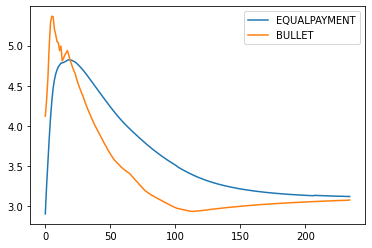

In [7]:
plt.plot(results['MONTHLY'].EQUALPAYMENT, label='EQUALPAYMENT')
plt.plot(results['MONTHLY'].BULLET, label='BULLET')
plt.legend()
plt.show()

In [8]:
evalDates = []
values = []

endDate = today + relativedelta(years=20)
baseData['PAYMENTFREQUENCY'] = 'MONTHLY'
for i in tqdm(range(0, 60)):
    evalDate = today+relativedelta(months=i)
    endDate = today+relativedelta(years=20, months=i)
    evalDates.append(evalDate)    
    baseData['STARTDATE'] = evalDate.strftime('%d%m%Y')
    baseData['ENDDATE'] = endDate.strftime('%d%m%Y')
    values.append(atlaspython.equalPaymentParRate(baseData)*100)

df = pd.DataFrame({'Date': evalDates, 'Value': values})

100%|██████████| 60/60 [00:01<00:00, 37.68it/s]
